In [1]:
import time

from dask.distributed import Client
import dask.dataframe as dd
import numpy as np
import pandas as pd
import dask

## Data Preparation

In [2]:
_TMP_FILE_NAME = "tmp.csv"
SIZE = 1_000_000

group_index = [1, 2, 3, 4, 5]
groups = group_index * int(SIZE / len(group_index))
numbers = np.random.default_rng(seed=20).random((SIZE,))

numbers = numbers * 100
numbers = numbers.astype("int")

In [3]:
%%time
df_pd = pd.DataFrame(
    data={
        "group": groups,
        "amount": numbers,
    }
)

df_pd.to_csv(path_or_buf=_TMP_FILE_NAME, index=False)

print(df_pd.shape)
df_pd.head(3)

(1000000, 2)
CPU times: user 873 ms, sys: 47.5 ms, total: 921 ms
Wall time: 1.95 s


,group,amount
0,1,28
1,2,46
2,3,12


In [4]:
%%time
df_dd = dd.read_csv(
    urlpath=_TMP_FILE_NAME,
    dtype={
        "group": "int",
        "amount": "int",
    } # specify dtype in case inference failing
)

print(df_dd.shape)
df_dd.head(3)

(Delayed('int-0e21b83f-5ef3-43cb-a68a-7b5600eda8bb'), 2)
CPU times: user 90.8 ms, sys: 29.9 ms, total: 121 ms
Wall time: 177 ms


,group,amount
0,1,28
1,2,46
2,3,12


In [5]:
%%time

df_pd.tail(2)

CPU times: user 307 µs, sys: 0 ns, total: 307 µs
Wall time: 331 µs


,group,amount
999998,4,42
999999,5,42


In [6]:
%%time

df_dd.tail(2)

CPU times: user 72.5 ms, sys: 13.2 ms, total: 85.7 ms
Wall time: 89 ms


,group,amount
999998,4,42
999999,5,42


## Performance Comparison

Though pandas's DataFrame is faster than Dask's in this case, Dask is more flexible and could fit into memory if data size is gigantic.

#### Via Pandas

In [7]:
%%time
mean_amount = df_pd.groupby("group")["amount"].mean()
mean_amount

CPU times: user 13.5 ms, sys: 5.23 ms, total: 18.7 ms
Wall time: 21.8 ms


group
1    49.657135
2    49.605740
3    49.534620
4    49.571390
5    49.535220
Name: amount, dtype: float64

#### Via Dask

In [8]:
%%time
mean_amount = df_dd.groupby("group")["amount"].mean()
mean_amount

CPU times: user 8.53 ms, sys: 0 ns, total: 8.53 ms
Wall time: 10.7 ms


Dask Series Structure:
npartitions=1
    float64
        ...
Name: amount, dtype: float64
Dask Name: truediv, 6 tasks

In [9]:
%%time
mean_amount.compute()

CPU times: user 105 ms, sys: 17.3 ms, total: 123 ms
Wall time: 116 ms


group
1    49.657135
2    49.605740
3    49.534620
4    49.571390
5    49.535220
Name: amount, dtype: float64

### Intermediate Sharing
Some individual computations may related to each other, so it could have performance gain if intermediate results are shared.

In [10]:
grouped = df_dd["amount"]

max_amount = grouped.max()
min_amount = grouped.min()
mean_amount = grouped.mean()

In [11]:
%%time
# without sharing
max_amount.compute(), min_amount.compute(), mean_amount.compute()

CPU times: user 215 ms, sys: 28.3 ms, total: 243 ms
Wall time: 250 ms


(99, 0, 49.580821)

In [12]:
%%time
# with sharing
dask.compute(max_amount, min_amount, mean_amount)

CPU times: user 87.3 ms, sys: 4.82 ms, total: 92.1 ms
Wall time: 98.5 ms


(99, 0, 49.580821)

### Array

#### Via Numpy

In [13]:
%%time
x = np.ones((10_000, 10_000), dtype=int)
x

CPU times: user 54.4 ms, sys: 312 ms, total: 366 ms
Wall time: 374 ms


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [14]:
%%time
f"{x.sum():,}"

CPU times: user 85.7 ms, sys: 1.42 ms, total: 87.1 ms
Wall time: 85.5 ms


'100,000,000'

In [15]:
x = np.ones((1_000_000_000, 1_000_000_000), dtype=int)
x

MemoryError: Unable to allocate 6.94 EiB for an array with shape (1000000000, 1000000000) and data type int64

#### Via Dask

In [16]:
%%time
x = dask.array.ones((10_000, 10_000), chunks=(100, 100), dtype=int)
x

CPU times: user 2.31 ms, sys: 53 µs, total: 2.36 ms
Wall time: 2.22 ms


dask.array<ones_like, shape=(10000, 10000), dtype=int64, chunksize=(100, 100), chunktype=numpy.ndarray>

In [17]:
%%time
result = x.sum()

CPU times: user 80.4 ms, sys: 4.56 ms, total: 85 ms
Wall time: 84 ms


In [18]:
%%time
f"{result.compute():,}"

CPU times: user 3.22 s, sys: 1.19 s, total: 4.41 s
Wall time: 4 s


'100,000,000'

In [19]:
%%time
# do not compute it since it may freeze and break the machine
x = dask.array.ones((1_000_000_000, 1_000_000_000), chunks=(10_000, 10_000), dtype=int)
x

CPU times: user 181 ms, sys: 0 ns, total: 181 ms
Wall time: 182 ms


dask.array<ones_like, shape=(1000000000, 1000000000), dtype=int64, chunksize=(10000, 10000), chunktype=numpy.ndarray>

### Delayed

In [20]:
def add(x, y=1):
    time.sleep(1)
    return x + y

In [21]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

#### When it runs sequentially:

In [22]:
%%time

results = []
for x in data:
    y = add(x)
    results.append(y)
    
sum(results)

CPU times: user 5.36 ms, sys: 6.81 ms, total: 12.2 ms
Wall time: 8.03 s


44

#### When it runs parallely with `delayed`：

Aggregation without `delayed` -

In [23]:
%%time

results = []
for x in data:
    y = dask.delayed(add)(x)
    results.append(y)

total = sum(results)
total

CPU times: user 5.99 ms, sys: 1.75 ms, total: 7.74 ms
Wall time: 7.61 ms


Delayed('add-aa797e8a98fdef7fe35a4d9847055cf5')

In [24]:
%%time

total.compute()

CPU times: user 8.8 ms, sys: 5.47 ms, total: 14.3 ms
Wall time: 2.01 s


44

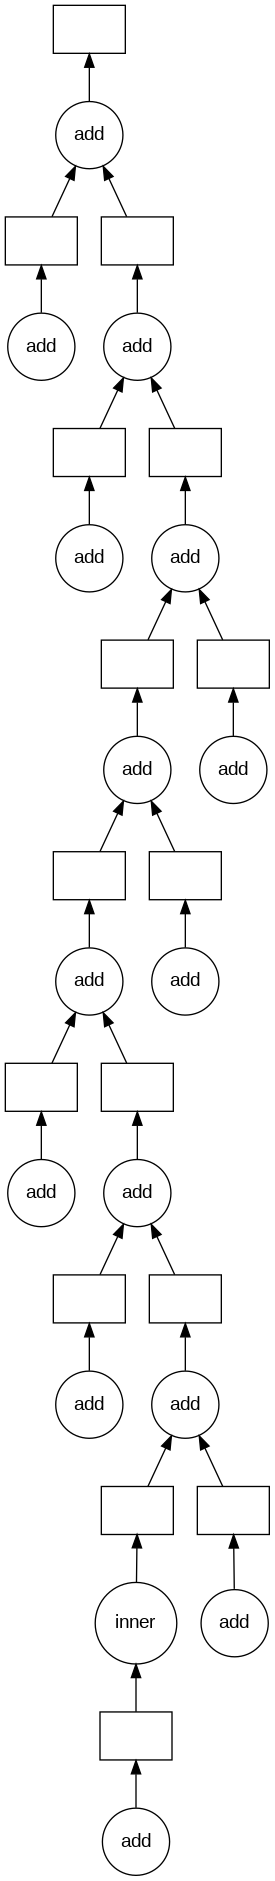

In [25]:
total.visualize()

Aggregation with `delayed` -

In [26]:
%%time

results = []
for x in data:
    y = dask.delayed(add)(x)
    results.append(y)

total = dask.delayed(sum)(results)
total

CPU times: user 1.87 ms, sys: 2.36 ms, total: 4.23 ms
Wall time: 4.99 ms


Delayed('sum-436eeb7a-dbf8-4105-a9c6-8706ea609b0c')

In [27]:
%%time

total.compute()

CPU times: user 7.62 ms, sys: 5.49 ms, total: 13.1 ms
Wall time: 1.98 s


44

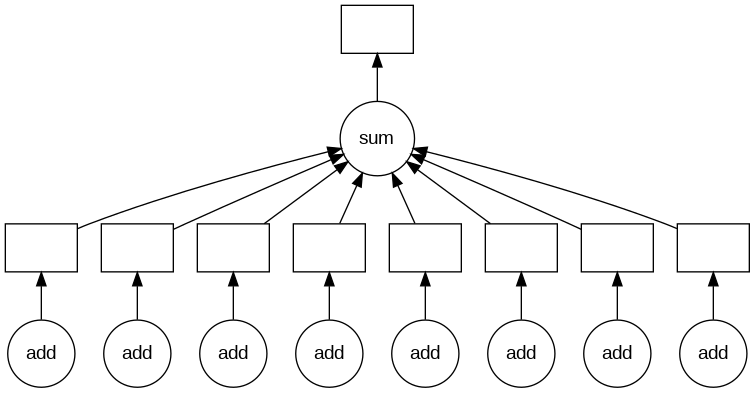

In [28]:
total.visualize()

#### Delayed file reading

In [29]:
%%time

csv_files = []

sums = []
counts = []

for file_name in csv_files:
    df = dask.delayed(pd.read_csv)(file_name)
    
    df_group = df.groupby("{group}")
    
    amount = df_group["{col}"].sum()
    total = df_group["{col}"].count()
    
    sums.append(amount)
    counts.append(total)

# compute the intermediates via sharing
sums, counts = dask.compute(sums, counts)

mean = sum(sums) / sum(counts)
mean

ZeroDivisionError: division by zero

## Dask Client

In [30]:
client = Client(n_workers=4)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 1.94 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42325,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 1.94 GiB
Comm: tcp://10.0.5.2:43519,Total threads: 1
Dashboard: http://10.0.5.2:46413/status,Memory: 496.43 MiB
Nanny: tcp://127.0.0.1:39055,


In [31]:
client.close()